In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


loan = pd.read_csv('accepted_2007_to_2018Q4.csv')

return_number = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

def convert_date(d):
    try:
        return datetime.date(year=int(d[4:]), month=return_number[d[:3]], day=1)
    except:
        pass

loan['issue_d'] = loan['issue_d'].apply(convert_date)
loan['earliest_cr_line'] = loan['earliest_cr_line'].apply(convert_date)

loan = loan[loan.issue_d < datetime.date(2015,7,1)]
loan = loan[loan.issue_d >= datetime.date(2010,1,1)]

loan = loan[loan.term == ' 36 months']

loan['earliest_cr_line'] = loan.apply(lambda x: (x['issue_d'] - x['earliest_cr_line']).days, axis=1)

loan = loan[(loan.loan_status == 'Fully Paid') | (loan.loan_status == 'Charged Off')]

loan = loan[loan.annual_inc < 1000000]

loan['ln_annual_inc'] = np.log(loan.annual_inc)

loan = loan[loan.revol_util < 150]
loan['ln_revol_bal'] = np.log(loan.revol_bal+1)

loan['ln_earliest_cr_line'] = np.log(loan.earliest_cr_line)

loan['ln_open_acc'] = np.log(loan.open_acc)

loan.rename(columns = {'delinq_2yrs': 'num_delinq_2yrs'}, inplace=True)
loan['delinq_2yrs'] = (loan['num_delinq_2yrs'] >= 1)

loan.rename(columns = {'pub_rec': 'num_pub_rec'}, inplace=True)
loan['pub_rec'] = (loan['num_pub_rec'] >= 1)

loan.rename(columns = {'inq_last_6mths': 'num_inq_last_6mths'}, inplace=True)
loan['inq_last_6mths'] = (loan['num_inq_last_6mths'] >= 1)

loan['target'] = (loan['loan_status'] == 'Fully Paid')

In [2]:
col_list = ['loan_amnt', 'int_rate', 'ln_annual_inc', 'dti', 'fico_range_high', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'num_inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'ln_open_acc', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']


In [3]:
# We will use 2010-2013 to tune our models, and save data from 2014 and the first 
# 6 months of 2015 for walk-forward testing

train = loan[loan.issue_d < datetime.date(2014, 1, 1)]
test = loan[(loan.issue_d >= datetime.date(2014, 1, 1)) & (loan.issue_d < datetime.date(2015, 1, 1))]
wf = loan[(loan.issue_d >= datetime.date(2015, 1, 1)) & (loan.issue_d < datetime.date(2015, 7, 1))]



In [4]:
y = train['target']
X1 = train[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2 = pd.concat([X1, train.int_rate, pd.get_dummies(train.grade)], axis=1)
X3 = pd.concat([X1, train.int_rate, pd.get_dummies(train.sub_grade)], axis=1)


In [5]:
X1_test = test[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.grade)], axis=1)
X3_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.sub_grade)], axis=1)
y_test = test['target']

In [6]:
from sklearn.model_selection import RandomizedSearchCV


In [13]:
def graph_by_grade(predictions, grade, target):
    pred = []
    act = []
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    
    plt.figure(figsize=(12,6))
    plt.subplot(2,4,1)
    plt.title("Overall")
    
    for i in range(21):
        
        lb = .58 + i*.02
        ub = .58 + (i+1)*.02
        sub = ((predictions >= lb)&(predictions < ub))
        pred_compliance = predictions[sub].mean()
        act_compliance = target[sub].mean()
        pred.append(pred_compliance)
        act.append(act_compliance)

    plt.plot(pred, act)
    plt.plot(pred, pred)

    for letter in range(7):
        
        pred = []
        act = []
        ss = []
        
        for i in range(21):
            lb = .58 + i*.02
            ub = .58 + (i+1)*.02
            sub = ((predictions >= lb)&(predictions < ub)&(grade==letters[letter]))
            pred_compliance = predictions[sub].mean()
            act_compliance = target[sub].mean()
            pred.append(pred_compliance)
            act.append(act_compliance)

        plt.subplot(2,4,letter+2)
        plt.title('Loan Grade: {}'.format(letters[letter]))
        plt.plot(pred, act)
        plt.plot(pred, pred)
    
    plt.show()



def returns_by_grade(metric, grade, returns, thresh = [80, 90, 95]):
    for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        
        cutoffs = [np.percentile(metric[grade == letter], q=x) for x in thresh]
        
        print('--------------  ' + letter + '  --------------')
        print('')
    
        print('Naive Returns:             {}%'.format(round(returns[grade==letter].mean()*100, 2)))
        print('')
        
        for c in range(len(thresh)):
            print('{} Percent Cutoff:         {}%'.format(thresh[c], round(returns[(grade == letter) & (metric >= cutoffs[c])].mean()*100,2)))
            
        print('')
        
#returns_by_grade(test.pred2, test.grade, test.pct_return)


In [8]:
from sklearn import ensemble

gb1 = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, loss='deviance')
gb1.fit(X2, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

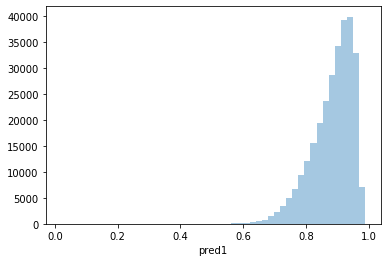

In [11]:
test['pred1'] = [x[1] for x in gb1.predict_proba(X2_test)]
sns.distplot(test.pred1, kde=False)
plt.show()

In [27]:
roc_auc_score(test.target, test.pred1)

0.6646854731649381

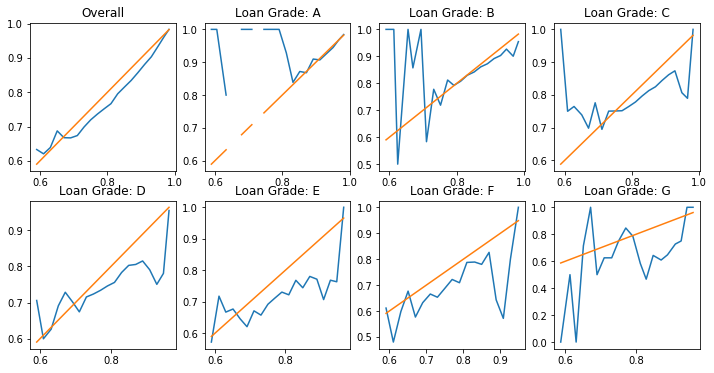

In [14]:
graph_by_grade(test.pred1, test.grade, test.target)

In [31]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [1,2,3,4,5,7,10],
    'loss': ['deviance', 'exponential'],
    'learning_rate': [.05, .1, .15, .25, .5],
    'max_features': [1,2,3,5,7,10,15,23]
}

gb2 = ensemble.GradientBoostingClassifier(n_estimators=500)

gb2_random = RandomizedSearchCV(estimator=gb2, param_distributions=param_grid, n_iter=50, cv=5, random_state=17)

gb2_random.fit(X2,y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [33]:
gb2_random.cv_results_

results = pd.DataFrame([gb2_random.cv_results_['mean_fit_time'],
                       [x['learning_rate'] for x in gb2_random.cv_results_['params']],
                        [x['loss'] for x in gb2_random.cv_results_['params']],
                        [x['max_depth'] for x in gb2_random.cv_results_['params']],
                        [x['max_features'] for x in gb2_random.cv_results_['params']],
                        gb2_random.cv_results_['rank_test_score']
                       ])

results = results.transpose()

results.rename(columns={0:'run_time', 1:'learning_rate', 2:'loss', 3:'max_depth', 4:'max_features', 5:'rank'}, inplace=True)

results[results['rank']<=10]

,run_time,learning_rate,loss,max_depth,max_features,rank
1,14.4419,0.05,exponential,1,3,1
11,39.0914,0.05,deviance,1,15,4
14,21.9132,0.1,exponential,4,1,9
23,14.3539,0.1,deviance,1,3,4
25,14.1387,0.25,deviance,1,3,10
28,8.66628,0.25,exponential,1,1,8
30,37.5677,0.05,exponential,2,7,1
32,103.93,0.05,exponential,2,23,1
42,26.9678,0.1,exponential,1,10,4
43,10.8727,0.1,exponential,1,2,4


In [39]:
results[results['rank']==1]

,run_time,learning_rate,loss,max_depth,max_features,rank
1,14.4419,0.05,exponential,1,3,1
30,37.5677,0.05,exponential,2,7,1
32,103.93,0.05,exponential,2,23,1


In [34]:
gb3 = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, learning_rate=.05, loss='exponential', max_features=3)
gb3.fit(X2, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='exponential', max_depth=2,
                           max_features=3, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

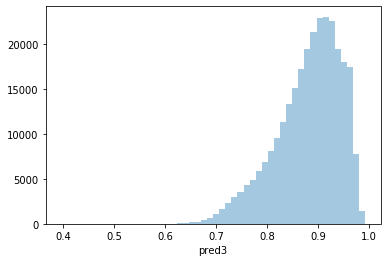

In [35]:
sns.distplot(test.pred3, kde=False)
plt.show()

In [36]:
roc_auc_score(test.target, test.pred3)

0.6660368127465216

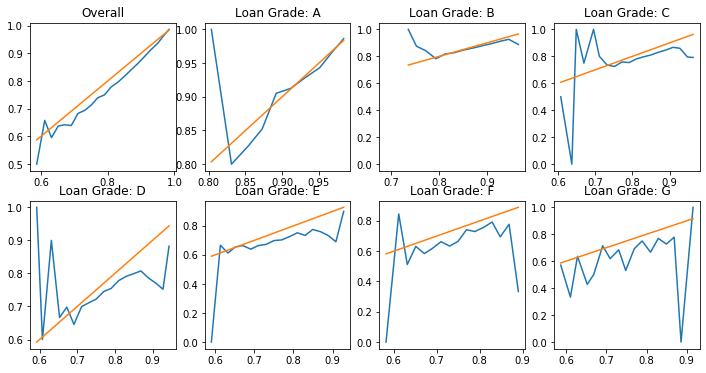

In [37]:
graph_by_grade(test.pred3, test.grade, test.target)

In [40]:
gb4 = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=2, learning_rate=.05, loss='exponential', max_features=7)
gb4.fit(X2, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='exponential', max_depth=2,
                           max_features=7, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

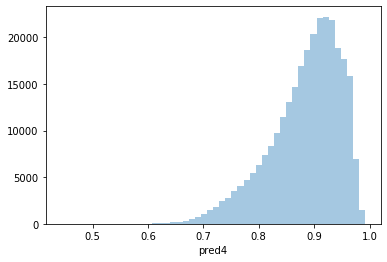

In [41]:
test['pred4'] = [x[1] for x in gb4.predict_proba(X2_test)]
sns.distplot(test.pred4, kde=False)
plt.show()

In [42]:
roc_auc_score(test.target, test.pred4)

0.6659834339531117

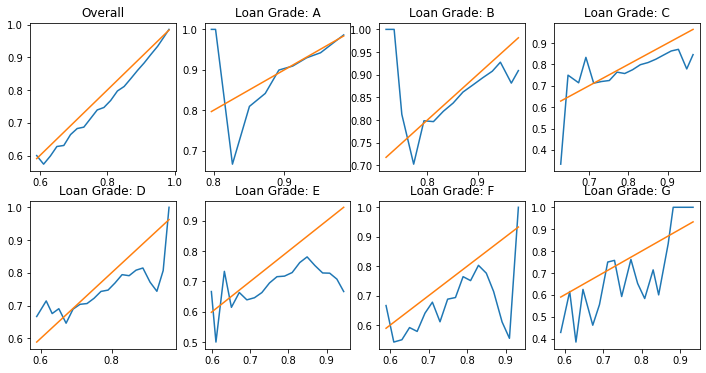

In [43]:
graph_by_grade(test.pred4, test.grade, test.target)

In [47]:
def total_int_paid(n, i):
    ii = i/12
    return n*(ii * (1 + ii) ** n) / ((1+ii)**n - 1)-1

test['total_int_paid'] = test.apply(lambda x: total_int_paid(36, x['int_rate']/100), axis=1)

test['ev1'] = test['pred1'] * test['total_int_paid'] - (1 - test['pred1']) * .37
test['ev3'] = test['pred3'] * test['total_int_paid'] - (1 - test['pred3']) * .37
test['ev4'] = test['pred4'] * test['total_int_paid'] - (1 - test['pred4']) * .37

test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt


In [48]:
returns_by_grade(test.ev1, test.grade, test.pct_return, [80, 90, 95, 99])

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         8.04%
90 Percent Cutoff:         8.4%
95 Percent Cutoff:         8.8%
99 Percent Cutoff:         9.47%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         10.58%
90 Percent Cutoff:         11.31%
95 Percent Cutoff:         11.9%
99 Percent Cutoff:         12.58%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         10.66%
90 Percent Cutoff:         10.64%
95 Percent Cutoff:         10.53%
99 Percent Cutoff:         9.31%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         10.75%
90 Percent Cutoff:         10.78%
95 Percent Cutoff:         10.33%
99 Percent Cutoff:         13.02%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         11.0%
90 Percent Cutoff:         10.34%
95 Percent Cutoff:         10.3%
99 Percent Cutof

In [49]:
returns_by_grade(test.ev3, test.grade, test.pct_return, [80, 90, 95, 99])

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         8.06%
90 Percent Cutoff:         8.42%
95 Percent Cutoff:         8.99%
99 Percent Cutoff:         9.53%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         10.63%
90 Percent Cutoff:         11.06%
95 Percent Cutoff:         11.82%
99 Percent Cutoff:         12.71%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         10.5%
90 Percent Cutoff:         10.6%
95 Percent Cutoff:         10.34%
99 Percent Cutoff:         9.29%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         10.62%
90 Percent Cutoff:         11.16%
95 Percent Cutoff:         10.89%
99 Percent Cutoff:         10.35%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         10.53%
90 Percent Cutoff:         11.15%
95 Percent Cutoff:         10.61%
99 Percent Cu

In [50]:
returns_by_grade(test.ev4, test.grade, test.pct_return, [80, 90, 95, 99])

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         8.08%
90 Percent Cutoff:         8.43%
95 Percent Cutoff:         8.75%
99 Percent Cutoff:         9.49%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         10.47%
90 Percent Cutoff:         11.23%
95 Percent Cutoff:         11.97%
99 Percent Cutoff:         12.49%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         10.55%
90 Percent Cutoff:         10.78%
95 Percent Cutoff:         10.3%
99 Percent Cutoff:         9.61%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         10.73%
90 Percent Cutoff:         11.28%
95 Percent Cutoff:         10.91%
99 Percent Cutoff:         12.12%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         10.93%
90 Percent Cutoff:         11.07%
95 Percent Cutoff:         9.82%
99 Percent Cu

hello
